# GOAL

so for this first implementation of a concept head, we're just gonna attempt to extend the context length of the model by giving the GPT a kind of recurrent hidden state that basically summarizes the previous length t window that it was looking at. to make this work imma have to train on the last context length chunk of the total sequence first, and then work backwards. each time i'll be passing the concept vector that was wanted to the previous chunk, and then regression / cosine similarity training on it. if i had a dataset other than tinyshakespeare that actually had \<endoftext> tokens then it'd be interesting to train that last context length chunk of the sequence to predict that token. Also I might need a learnable token to separate the concept from the rest of the sequence

a limitation of this approach is that it only works in chunks of the context length. if it works well then this is useful bc it means we could use a shorter context length which is important because attention is quadratic in its use of compute as a function of context length. however it's not clear whether the current approach will work with varying context lengths or if it'll only give us a useable context vector for the pre-determined context length t

yoooo so to speed up inference what if i ran a bunch of inferences on a bunch of sequences & got all the concept vectors that came out, then trained a GPT using cosine similarity regression rather than CEL classification to predict future concept vectors. then what i'd be able to do is after the first t tokens are created this meta-model could use the concept vector that's outputted to create all the future concept vectors, then i could run the actual model in parallel for inference

in a future version i would like to allow the model to carry over all previous concept vectors it has made from this sequence rather than just the most recent one

at some point i'd like to solve that dynamic context length problem. one idea i've got is to use a dataset with actual documents that end in \<endoftext> tokens. basically i'd take the total sequence length of the document and divide by k, then do my batch training on context lengths of that size. i'd have to match up documents of the same size. and i'd have to switch from learned pos embeddings to RoPE. 

Another idea to potentially explore is to use the unused outputs of the regression head for something. maybe hyperparameter control or creating higher-level concept vectors

after that i would like to train the model on a dataset of separate documents where each document provides its own concept vector, so this model can essentially be used to extend my obsidian graph

a big assumption with this model is that the embedding space is actually capable of carrying surprisingly complicated concepts, far more than the number of tokens

another half-baked idea for the generation process is to 

#### !!!! DO NOT RUN THIS FIRST CELL UNLESS YOU HAVE THE SAME VENV PATH ISSUE THAT I DO

In [1]:
import sys
sys.path.append('/Users/tunadorable/local-repos/learning_medusa/venv/lib/python3.11/site-packages')

In [2]:
import torch
import torch.nn as nn
from torch.nn import functional as F
import time
import random

#### !!!! ONLY FOR APPLE SILICON
make your own if u use cuda

In [3]:
device = 'mps' if torch.backends.mps.is_available() else 'cpu'

In [4]:
# hyperparameters
b = 24 # how many independent sequences will we process in parallel?
t = 32 # what is the maximum context length for predictions?
max_iters = 1000
eval_interval = 10
lr = 3e-4 # learning rate for each backprop step
eval_iters = 10
d = 128 # embedding aka hidden dimension
h = 8 # number of attention heads
l = 8 # number of transormer layers
dropout = 0.2 # % of parameters to ignore every iteration
l2 = 0.01 # multiplier for our L2 norm to encourage sparsity

k = 4

In [5]:
# the dataset is TinyShakespeare
with open('input.txt', 'r', encoding='utf-8') as f:
    text = f.read()

In [6]:
# here are all the unique characters that occur in this text
# we'll be using individual characters instead of tokens
chars = sorted(list(set(text)))
chars.append('') # a learnable token we'll use later
v = len(chars)
print(chars, v)

['\n', ' ', '!', '$', '&', "'", ',', '-', '.', '3', ':', ';', '?', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', ''] 66


In [7]:
# create a mapping from characters to integers & vice versa
stoi = { ch:i for i,ch in enumerate(chars) }
itos = { i:ch for i,ch in enumerate(chars) }
encode = lambda s: [stoi[c] for c in s] # encoder: take a string, output a list of integers
decode = lambda l: ''.join([itos[i] for i in l]) # decoder: take a list of integers, output a string

In [8]:
# Train and test splits
data = torch.tensor(encode(text), dtype=torch.long)
n = int(0.9*len(data)) # first 90% will be train, rest val
train_data = data[:n]
val_data = data[n:]
print(len(train_data), len(val_data))

1003854 111540


In [9]:
def get_batch(split, k=k, b=b, t=t):
    # Assume train_data and val_data are defined outside this function
    data = train_data if split == 'train' else val_data
    max_index = len(data) - k * t
    ix = torch.randint(max_index, (b,))

    # Initialize x and y
    x = torch.zeros((k, b, t), dtype=data.dtype).to(device)
    y = torch.zeros((k, b, t), dtype=data.dtype).to(device)

    # Fill in x and y
    for i in range(k):
        x[i] = torch.stack([data[j+i*t:j+i*t+t] for j in ix])
        y[i] = torch.stack([data[j+i*t+1:j+i*t+t+1] for j in ix])

    return x, y

In [10]:
# so you can see what the tokenized data looks like
x,y = get_batch('train')
print("x ", x.shape, "\n", x) # instead of (b,t) it's (k,b,t)
print("y ", y.shape, "\n", y)
t1, t2, t3, t4 = decode(x[0,0].tolist()), decode(x[1,0].tolist()), decode(x[2,0].tolist()), decode(x[3,0].tolist())
print("the spaces are messed up only bc of how print() works: \n", t1,t2,t3,t4)

x  torch.Size([4, 24, 32]) 
 tensor([[[41, 53, 52,  ..., 54, 43, 39],
         [27, 30, 15,  ...,  1, 51, 53],
         [63,  6,  1,  ...,  0, 13, 57],
         ...,
         [53, 60, 53,  ...,  5, 57,  1],
         [21,  1, 51,  ..., 42, 53,  5],
         [ 1, 53, 44,  ...,  0, 27, 44]],

        [[49,  8,  0,  ..., 11,  1, 47],
         [52, 58, 46,  ..., 39, 56,  1],
         [ 1, 63, 53,  ...,  1, 39, 54],
         ...,
         [63, 53, 59,  ..., 34, 21, 26],
         [58,  6,  1,  ..., 40, 56, 43],
         [ 1, 61, 46,  ..., 25, 17, 26]],

        [[58,  1, 47,  ...,  1, 53, 39],
         [51, 63,  1,  ..., 63,  0, 53],
         [54, 43, 39,  ..., 63,  6,  1],
         ...,
         [15, 17, 26,  ..., 52, 42,  1],
         [39, 49,  7,  ..., 61,  2,  0],
         [17, 26, 21,  ..., 47, 58, 46]],

        [[58, 46,  1,  ...,  1, 58, 53],
         [41, 41, 59,  ..., 59,  8,  0],
         [40, 53, 58,  ..., 42,  1, 50],
         ...,
         [51, 63,  1,  ..., 47, 58,  1],
       

In [11]:
@torch.no_grad()
def estimate_loss():
    out = {}
    model.eval() # sets model to eval mode
    for split in ['train', 'val']:
        losses = torch.zeros(eval_iters)
        for j in range(eval_iters):
            X, Y = get_batch(split)

            # how we'll keep track of this iteration's total loss
            loss_sum = torch.tensor(0.0, device=device)
            
            # initlaize c_vecs so that the model will use the empty token '' on first go
            c_vecs=None
            
            for i in range(k):
                # notice how we can get loss without testing on c_hat bc at the end of the day only NTP loss matters
                # c_hat loss is just a means to an end
                logits, c_vecs, loss = model(idx=X[i,...], targets=Y[i,...], c_vecs=c_vecs)
                loss_sum += loss

            losses[j] = (loss_sum/k).item()
        out[split] = losses.mean()
    model.train() # just resets to training mode
    return out

In [12]:
class FeedForward(nn.Module):
    """ a simple linear layer followed by a non-linearity """

    def __init__(self, d):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(d, 4 * d), # the 4 is arbitrary, but i wouldn't go smaller
            nn.ReLU(), 
            nn.Linear(4 * d, d),
            nn.Dropout(dropout))

    def forward(self, x):
        return self.net(x)

In [13]:
class Head(nn.Module):
    """ one head of self-attention """

    def __init__(self, head_size):
        super().__init__()
        self.key = nn.Linear(d, head_size, bias=False)
        self.query = nn.Linear(d, head_size, bias=False)
        self.value = nn.Linear(d, head_size, bias=False)
        self.register_buffer('tril', torch.tril(torch.ones(1+t,1+t))) # mask future timestesps # 1+ for the prepended concept vec
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        # input of size (batch, time-step, channels)
        # output of size (batch, time-step, head size)
        b,t,d = x.shape
        k = self.key(x)   # (b,t,d/h)
        q = self.query(x) # (b,t,d/h)
        # compute attention scores ("affinities")
        wei = q @ k.transpose(-2,-1) * k.shape[-1]**-0.5 # (b, t, d/h) @ (b, d/h, t) -> (b, t, t)
        wei = wei.masked_fill(self.tril[:t, :t] == 0, float('-inf')) # (b, t, t)
        wei = F.softmax(wei, dim=-1) # (b, t, t)
        wei = self.dropout(wei)
        # perform the weighted aggregation of the values
        v = self.value(x) # (b,t,d/h)
        out = wei @ v # (b, t, t) @ (b, t, d/h) -> (b, t, d/h)
        return out

In [14]:
class MultiHeadAttention(nn.Module):
    """ multiple heads of self-attention in parallel """

    def __init__(self, h, head_size):
        super().__init__()
        self.heads = nn.ModuleList([Head(head_size) for _ in range(h)])
        self.proj = nn.Linear(head_size * h, d)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        out = torch.cat([head(x) for head in self.heads], dim=-1)
        out = self.dropout(self.proj(out))
        return out

In [15]:
class Block(nn.Module):
    """ Transformer block: communication followed by computation """

    def __init__(self, d, h):
        # d: embedding dimension, h: the number of heads we'd like
        super().__init__()
        head_size = d // h # the double backslash just makes the output an int instead of float
        self.sa = MultiHeadAttention(h, head_size)
        self.ffwd = FeedForward(d)
        self.ln = nn.LayerNorm(d, elementwise_affine=False)

    def forward(self, x):
        x = x + self.sa(self.ln(x))
        x = x + self.ffwd(self.ln(x))
        return x

In [17]:
class conceptGPTv9(nn.Module):
    def __init__(self):
        super().__init__()
        # each token directly reads off the logits for the next token from a lookup table
        self.token_embedding_table = nn.Embedding(v, d)
        self.vocab_len = v
        
        # simple learned positional encodings rather than sine or RoPE
        self.position_embedding_table = nn.Embedding(t+1, d) # +1 for c or the learnable token
        
        # bulk of the beast
        self.blocks = nn.Sequential(*[Block(d, h) for _ in range(l)]) 
        
        # output head
        self.lm_head = nn.Linear(d, v) 
        
        # apparently layernorm by default actually adds a linear layer & bias unless you specificaly specify false
        # if you're gonna re-use the same layernorm object then you should specify false
        self.ln = nn.LayerNorm(d, elementwise_affine=False) # final layer norm
        
        # the concept head
        self.conc_head = FeedForward(d)

        # Initialize Cosine Similarity module here
        self.cosine_similarity = nn.CosineSimilarity(dim=1)

        # according to Andrej Karpathy this _init_weights method is better than default
        self.apply(self._init_weights)
    
    def _init_weights(self, module):
        if isinstance(module, nn.Linear):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)
            if module.bias is not None:
                torch.nn.init.zeros_(module.bias)
        elif isinstance(module, nn.Embedding):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)
    
    def forward(self, idx=None, targets=None, c_vecs=None, c_hat=None, verbose=False):
        # c_hat is your target concept vectors
        
        # ik it's crazy but you can in fact not pass in a sequence & still have it perform inference
        b, t = (idx.shape[0],idx.shape[1]) if idx is not None else (1,0)
        # in theory you should only do this for v9.2 where we use c_vecs to massively parallelize inference
            
        # if there's no input concept vector we use the learned token ''
        if c_vecs is None:
            # v-1 is the index of the '' token we added
            c_ind = (self.vocab_len-1)*torch.ones((b,1),device=device,dtype=torch.long) # (b,1)

            # turn it into the vector parts for residual later
            c_vecs = self.token_embedding_table(c_ind) # (b,1,d)

        # regular GPT pos embeddings but with 1+t as our context length
        pos_emb = self.position_embedding_table(torch.arange(1+t, device=device)) # (1+t,d)

        # most scenarios idx should not be None. later when we do v9.2 it will be tho
        if idx is not None:
            tok_emb = self.token_embedding_table(idx) # (b,t,d)
            x = self.ln(torch.cat((c_vecs,tok_emb),dim=1) + pos_emb) # (b,1+t,d)
        else:
            # if there's no idx inputted, that means we're predicting based off either
            # - the learned token '' in the case that we're at the beginning of the sequence
            # - a c_vec that was passed in, meaning we're at the beginning of a chunk & no initial token was provided
            x = self.ln(c_vecs + pos_emb)
        
        # the bulk of the beast
        x = self.ln(self.blocks(x)) # (b,1+t,d) -> (b,1+t,d)
        
        # the regular next-token prediction head
        logits = self.lm_head(x)[:,1:,:] # ((b,1+t,d)@(d,v))[:,1:,:] -> (b,t,v)

        # the concept head is just a 2-layer feedforward, a splice to make it 1 vector per sequence, then a layernorm
        c_out = self.ln(self.conc_head(x).sum(1)).unsqueeze(1) # (b,1+t,d) -> (b,1,d)
        # the other indicies could be used for something else in the future

        if targets is None:
            # If we're not training at all, we can ignore loss
            loss = None
        else:
            # Regular NTP loss
            b, t, v = logits.shape
            ntp_loss = F.cross_entropy(logits.reshape(b*t, v), targets.reshape(b*t))
            
            if c_hat is not None:
                # Cosine similarity loss for concept vectors
                # this is similar to doing a regression since all layernormed vectors have roughly the same radius anyways
                # except unlike MSE or MAE, it lets us interpret all c's as vectors in embedding space
                similarity = self.cosine_similarity(c_out, c_hat)

                # Maximizing cosine similarity is equivalent to minimizing 1 - cosine similarity
                c_loss = 1 - similarity.mean()  
        
                # might try a different way to balance the two in the future. for now we'll multiply by sqrt(t)
                loss = ntp_loss + (c_loss*(t**-0.5))
            else:
                # If we're on the first run of training
                # aka don't have a c_hat
                # aka we're at the end of the sequence
                loss = ntp_loss
        
        return logits, c_out, loss

    def generate_subsequence(self, idx, c_vecs, inp, start, end, temperature):
        """
        so this is the thing that generates subsequences of length <= t
        """
        for j in range(start, end):
            # now we're looking for that next token
            logits, c_inp, loss = model(idx=inp, c_vecs=c_vecs)
            
            # focus only on the last time step
            logits = logits[:, -1, :] # becomes (b, d)
            
            # scale logits by the temperature
            logits = logits / (temperature+1e-10)
            
            # apply softmax to get probabilities
            probs = F.softmax(logits, dim=-1) # (b, d)
            
            # sample from the distribution
            idx_next = torch.multinomial(probs, num_samples=1) # (b, 1)
            
            # to be inputted next inference run
            inp = torch.concat((inp, idx_next),dim=1)
            
            # keeping track of our total sequence
            idx = torch.concat((idx, idx_next),dim=1)
        
        return idx, c_inp
        
    def generate(self, idx, max_new_tokens=250, temperature=1.0):
        """
        the # notes assume we passed in as input "JULIET:\nO Romeo, Romeo! wherefore art thou R" with a context length of 8
        """
        b, i = idx.shape
    
        ##############################################
        #### getting the first concept vector(s) ####
        ##############################################

        # gonna keep all of our c_vecs for use later
        c_vecs_list = []

        context_chunks = i // t
        # if our provided context is longer than our context length
        if i >= t:
            # the subsequence we'll be performing inference on to get the first concept vec
            inp = idx[:,:t] # "JULIET:\n"
            # we want that first outputted concept vector
            logits, c_vecs, loss = model(idx=inp)
        
            # getting concept vectors for the next few length t parts of the input context
            for j in range(1,context_chunks): # "O Romeo," -> " Romeo! " -> "wherefor" -> "e art th" 
                # the subsequence we'll be performing inference on
                inp = idx[:,j*t:(j+1)*t]
            
                # all we care about is that next concept vector
                logits, c_vecs, loss = model(idx=inp, c_vecs=c_vecs)
            
            # defining c_inp since we won't want to use the newest c_vecs every time,
            # we only want to use c_vecs generated from a full length t subsequence since 
            # that's how the model was trained
            c_inp = c_vecs
            print("c_inp: ", c_inp)
            c_vecs_list.append(c_vecs.clone().detach().requires_grad_(False))
        else:
            c_inp = None
    
        ###########################
        #### Actual generation ####
        ###########################
        
        # beginning generation wherever the context leaves off
        partial_final_context_chunk = i % t
        # if it ==0 then that means the context is divisible by t so there's no partial chunk to finish, so we skip
        if partial_final_context_chunk != 0:
            # we'll use c_inp plus this as our context to generate off of
            inp = idx[:,-partial_final_context_chunk:]
            
            idx, c_inp = self.generate_subsequence(idx=idx, inp=inp, c_vecs=c_inp, start=partial_final_context_chunk, end=t+1, temperature=temperature)
            
            print("c_inp: ", c_inp)
            c_vecs_list.append(c_inp.clone().detach().requires_grad_(False))
                               
        # all of the remaining full chunks as defined by max_new_tokens
        full_chunks = (i + max_new_tokens) // t
        for k in range(context_chunks + 1, full_chunks):
            # the last step gave us both c_vecs and another NTP token
            inp = idx[:,-1].unsqueeze(0)

            idx, c_inp = self.generate_subsequence(idx=idx, inp=inp, c_vecs=c_inp, start=0, end=t, temperature=temperature)

            print("c_inp: ", c_inp)
            c_vecs_list.append(c_inp.clone().detach().requires_grad_(False))
            
        # the final remainder as defined by the number of chunks & max_new_tokens
        final_remainder = (i + max_new_tokens) % t
        if final_remainder != 0:
            # the last step gave us both c_vecs and another NTP token
            inp = idx[:,-1].unsqueeze(0)

            idx, c_vecs = self.generate_subsequence(idx=idx, inp=inp, c_vecs=c_inp, start=0, end=final_remainder, temperature=temperature)

            print("c_vecs: ", c_vecs)
            c_vecs_list.append(c_vecs.clone().detach().requires_grad_(False))
            
        return idx, c_vecs_list

# Training

if you don't want to do your own training just scroll down

In [18]:
model = conceptGPTv9().to(device)
# print the number of parameters in the model
print(sum(p.numel() for p in model.parameters())/1e3, 'K parameters')

1731.906 K parameters


In [19]:
# create a PyTorch optimizer
optimizer = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=l2)

In [20]:
start_time = time.time()
for iter in range(max_iters):
    
    # sample a batch of data
    xb, yb = get_batch('train')

    # initialize it. when this happens the system starts with a learned token '' where the concept vecs will be later
    c_hat = None
    
    # k is the number of subsequences we're training through
    for j in range(k-1):
        #print("j: ", j)
        
        # temporarily set model to evaluate mode since we're not backpropogating on this part
        model.eval()
        
        # initlaize c_vecs so that the model will use the empty token '' on first go
        c_vecs=None
        
        # forward pass to get list of concept vectors
        for i in range(k-1-j): # -1 bc i don't think we care about the last one
            logits, c_vecs, loss = model(xb[i,...], targets=yb[i,...], c_vecs=c_vecs)
        
        # saving a version to train with that's not attached to the gradient graph
        c_vecs_input = c_vecs.clone().detach().requires_grad_(True) # is .clone() necessary?
        #print("c_vecs_input: ", c_vecs_input)
        
        # put the model back into train mode
        model.train()
        
        # so now we can use that c_hat we made earlier to train on
        logits, c_vecs, loss = model(xb[k-1-j,...], targets=yb[k-1-j,...], c_vecs=c_vecs_input, c_hat=c_hat)
        
        optimizer.zero_grad(set_to_none=True)
        loss.backward()
        
        # creating this set of "ideal" concept vectors to train on
        with torch.no_grad():
            #print("c_vecs_input.grad: ", c_vecs_input.grad)
            c_prime = c_vecs_input - lr * c_vecs_input.grad  # Simple gradient descent step
        
        # making absolutely sure the gradient graphs are not connected for sake of memory savings
        # we'll be using this to train on
        c_hat = c_prime.clone().detach().requires_grad_(False)
        #print("c_hat: ", c_hat)
        #print("=???: ", c_vecs_input == c_hat)
        
        # so this actually implements the gradients
        optimizer.step()

    
    # the last iter doesn't need the model.eval() forward pass stuff, we just pass in empty c_vecs & train on c_hat
    logits, c_vecs, loss = model(xb[k-1-j,...], targets=yb[k-1-j,...], c_vecs=None, c_hat=c_hat) # xb[0,...]
    
    optimizer.zero_grad(set_to_none=True)
    loss.backward()
    optimizer.step()

    # every once in a while evaluate the loss on train and val sets
    if iter % eval_interval == 0 or iter == max_iters - 1:
        current_time = time.time()
        elapsed_time = current_time - start_time
        losses = estimate_loss()
        print(f"step {iter}: train loss {losses['train']:.4f}, val loss {losses['val']:.4f}, time elapsed: {elapsed_time:.2f} seconds")

step 0: train loss 3.8957, val loss 3.8962, time elapsed: 2.72 seconds
step 10: train loss 3.0659, val loss 3.1019, time elapsed: 27.66 seconds
step 20: train loss 2.7410, val loss 2.7602, time elapsed: 52.32 seconds
step 30: train loss 2.6448, val loss 2.6369, time elapsed: 76.93 seconds
step 40: train loss 2.5658, val loss 2.5812, time elapsed: 101.52 seconds
step 50: train loss 2.5139, val loss 2.5396, time elapsed: 126.12 seconds


KeyboardInterrupt: 

## save the trained model

In [22]:
torch.save(model.state_dict(), f'models/{model.__class__.__name__}_b{b}_t{t}_d{d}_h{h}_l{l}_lr{lr}_drop{dropout}_l2-{l2}_k{k}_{time.strftime("%Y-%m-%d|%H-%M-%S")}.pth')

# Load a saved model

In [18]:
model = conceptGPTv9().to(device)  # Initialize a model with the same architecture

# Load the saved state dictionary
model.load_state_dict(torch.load('models/conceptGPTv9_b24_t32_d128_h8_l8_lr0.0003_drop0.2_l2-0.01_k8_2024-02-02|04-39-06.pth'))

# If you plan to continue training the model, switch to training mode
#model.train()

# If you only plan to do inference, switch to evaluation mode
model.eval()

conceptGPTv9(
  (token_embedding_table): Embedding(66, 128)
  (position_embedding_table): Embedding(33, 128)
  (blocks): Sequential(
    (0): Block(
      (sa): MultiHeadAttention(
        (heads): ModuleList(
          (0-7): 8 x Head(
            (key): Linear(in_features=128, out_features=16, bias=False)
            (query): Linear(in_features=128, out_features=16, bias=False)
            (value): Linear(in_features=128, out_features=16, bias=False)
            (dropout): Dropout(p=0.2, inplace=False)
          )
        )
        (proj): Linear(in_features=128, out_features=128, bias=True)
        (dropout): Dropout(p=0.2, inplace=False)
      )
      (ffwd): FeedForward(
        (net): Sequential(
          (0): Linear(in_features=128, out_features=512, bias=True)
          (1): ReLU()
          (2): Linear(in_features=512, out_features=128, bias=True)
          (3): Dropout(p=0.2, inplace=False)
        )
      )
      (ln): LayerNorm((128,), eps=1e-05, elementwise_affine=False)


## Inference


In [19]:
#%%time # to keep track of how long it takes
input_str = "JULIET:"#\nO Romeo, Romeo! wherefore art thou R" # the classic line
context_tensor = torch.tensor([encode(input_str)], dtype=torch.long, device=device)
output, c_vecs_list = model.generate(context_tensor, max_new_tokens=250)
output_str = decode(output[0].tolist())
print(output_str)

c_inp:  tensor([[[ 8.2708e-01,  1.0221e+00, -7.9211e-01,  9.2623e-01,  7.6982e-01,
           1.2511e+00, -8.7318e-01, -1.0886e+00,  9.5743e-01,  1.2189e+00,
           1.0357e+00,  1.0200e-01,  1.0811e+00, -1.3206e+00,  1.1656e+00,
           5.8005e-01, -4.6287e-01,  1.3916e+00,  6.1738e-01, -3.5546e-01,
           2.0014e-01, -2.3878e-03,  1.1545e+00,  3.5537e-01, -1.0820e+00,
          -8.1670e-01, -1.0724e+00,  3.9128e-01, -1.1562e+00,  6.5255e-01,
          -7.0762e-01, -1.1580e+00,  9.8334e-01,  7.2269e-01,  8.5778e-01,
          -1.5771e-01,  3.6548e-01,  1.1385e+00, -9.6341e-01,  8.1605e-01,
          -1.1281e+00,  5.7120e-01, -2.8409e-01,  1.7405e+00,  6.0944e-01,
          -3.1421e-01, -7.9477e-01, -1.3378e+00,  7.6548e-01,  6.6579e-01,
           2.3620e-01, -2.8895e-01,  1.7436e+00,  1.0921e+00, -5.0467e-01,
          -1.0363e-01,  5.7172e-01,  3.0284e-01,  1.5272e-01, -4.1135e-01,
          -2.9390e+00, -5.5676e-01,  5.6799e-01,  4.9352e-02, -1.0181e-01,
          -7.5774

# analyzing token & concept embedding vectors

In [19]:
print(chars)

['\n', ' ', '!', '$', '&', "'", ',', '-', '.', '3', ':', ';', '?', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', '']


In [20]:
print(stoi)

{'\n': 0, ' ': 1, '!': 2, '$': 3, '&': 4, "'": 5, ',': 6, '-': 7, '.': 8, '3': 9, ':': 10, ';': 11, '?': 12, 'A': 13, 'B': 14, 'C': 15, 'D': 16, 'E': 17, 'F': 18, 'G': 19, 'H': 20, 'I': 21, 'J': 22, 'K': 23, 'L': 24, 'M': 25, 'N': 26, 'O': 27, 'P': 28, 'Q': 29, 'R': 30, 'S': 31, 'T': 32, 'U': 33, 'V': 34, 'W': 35, 'X': 36, 'Y': 37, 'Z': 38, 'a': 39, 'b': 40, 'c': 41, 'd': 42, 'e': 43, 'f': 44, 'g': 45, 'h': 46, 'i': 47, 'j': 48, 'k': 49, 'l': 50, 'm': 51, 'n': 52, 'o': 53, 'p': 54, 'q': 55, 'r': 56, 's': 57, 't': 58, 'u': 59, 'v': 60, 'w': 61, 'x': 62, 'y': 63, 'z': 64, '': 65}


In [21]:
print(itos)

{0: '\n', 1: ' ', 2: '!', 3: '$', 4: '&', 5: "'", 6: ',', 7: '-', 8: '.', 9: '3', 10: ':', 11: ';', 12: '?', 13: 'A', 14: 'B', 15: 'C', 16: 'D', 17: 'E', 18: 'F', 19: 'G', 20: 'H', 21: 'I', 22: 'J', 23: 'K', 24: 'L', 25: 'M', 26: 'N', 27: 'O', 28: 'P', 29: 'Q', 30: 'R', 31: 'S', 32: 'T', 33: 'U', 34: 'V', 35: 'W', 36: 'X', 37: 'Y', 38: 'Z', 39: 'a', 40: 'b', 41: 'c', 42: 'd', 43: 'e', 44: 'f', 45: 'g', 46: 'h', 47: 'i', 48: 'j', 49: 'k', 50: 'l', 51: 'm', 52: 'n', 53: 'o', 54: 'p', 55: 'q', 56: 'r', 57: 's', 58: 't', 59: 'u', 60: 'v', 61: 'w', 62: 'x', 63: 'y', 64: 'z', 65: ''}


In [67]:
# Access the embedding weight matrix
embedding_matrix = model.token_embedding_table.weight.data

# If you want to look at the embedding for a specific token index, say index 42
token = 'a'
token_index = stoi[token]
token_embedding = embedding_matrix[token_index]

print(f"Embedding for token '{token}' index {token_index}: {token_embedding}")

Embedding for token 'a' index 39: tensor([ 0.0370, -0.0047, -0.0409,  0.0261, -0.0056,  0.0389,  0.0012, -0.0172,
         0.0626,  0.0015, -0.0392,  0.0354,  0.0354, -0.0482,  0.0230, -0.0001,
        -0.0626, -0.0720, -0.0312, -0.0212, -0.0230,  0.0905, -0.0449, -0.0017,
        -0.0279,  0.0119,  0.0467, -0.0701, -0.0846, -0.0164, -0.0378,  0.0210,
        -0.0045,  0.0045,  0.0250, -0.0003,  0.0162,  0.0380, -0.0400,  0.0078,
        -0.0189, -0.0865, -0.0360, -0.0451, -0.0101,  0.0313, -0.0139, -0.0248,
        -0.0007,  0.0395,  0.0309, -0.0106, -0.0057, -0.0615,  0.0748, -0.0041,
         0.0654,  0.0131, -0.0116, -0.0031,  0.0244,  0.0197, -0.0061, -0.0188,
        -0.0202,  0.0224, -0.0085, -0.0159, -0.0267, -0.0106,  0.0097,  0.0499,
        -0.0289, -0.0205, -0.0437,  0.0131,  0.0951, -0.0308, -0.0236, -0.0514,
        -0.0542,  0.0762,  0.0946,  0.0207, -0.0100,  0.0366, -0.0183, -0.0024,
         0.0484, -0.0009, -0.0097,  0.0049,  0.0154, -0.0637, -0.0069,  0.0058,
      

In [68]:
def cosine_similarity(embedding1, embedding2):
    # Calculate the cosine similarity between two embeddings
    return F.cosine_similarity(embedding1.unsqueeze(0), embedding2.unsqueeze(0))

# Example tokens
token1 = 'a'
token2 = 'b'
token3 = 'o'

# Convert tokens to indices
index1 = stoi[token1]
index2 = stoi[token2]
index3 = stoi[token3]

# Retrieve embeddings from the model
embedding1 = model.token_embedding_table.weight[index1]
embedding2 = model.token_embedding_table.weight[index2]
embedding3 = model.token_embedding_table.weight[index3]

# Calculate cosine similarity
similarity = cosine_similarity(embedding1, embedding2)
print(f"Cosine similarity between '{token1}' and '{token2}':", similarity.item())
similarity = cosine_similarity(embedding1, embedding3)
print(f"Cosine similarity between '{token1}' and '{token3}':", similarity.item())


Cosine similarity between 'a' and 'b': 0.06943386793136597
Cosine similarity between 'a' and 'o': 0.2285880744457245


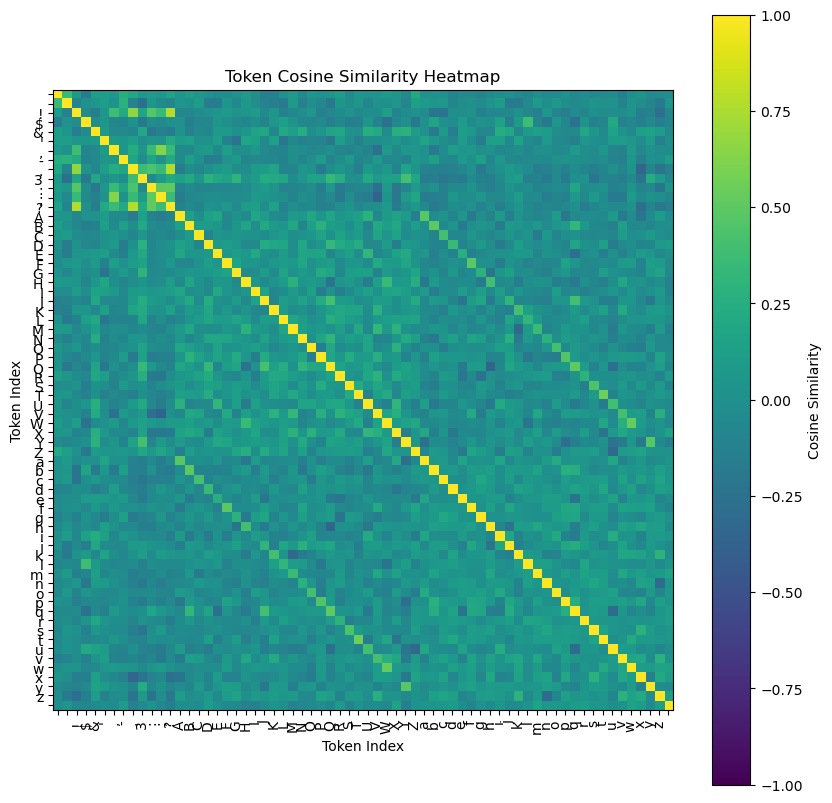

In [69]:
import matplotlib.pyplot as plt
import numpy as np

# Number of tokens
num_tokens = len(chars)

# Initialize a matrix to hold cosine similarities
cosine_sim_matrix = np.zeros((num_tokens, num_tokens))

# Compute cosine similarity for each pair of tokens
for i in range(num_tokens):
    for j in range(num_tokens):
        # Retrieve embeddings for token i and token j
        embedding_i = model.token_embedding_table.weight[i]
        embedding_j = model.token_embedding_table.weight[j]
        
        # Compute cosine similarity and store it in the matrix
        cosine_sim_matrix[i, j] = F.cosine_similarity(embedding_i.unsqueeze(0), embedding_j.unsqueeze(0)).item()

# Plotting the cosine similarity matrix as a heatmap
plt.figure(figsize=(10, 10))
plt.imshow(cosine_sim_matrix, cmap='viridis', interpolation='nearest', vmin=-1, vmax=1)
plt.colorbar(label='Cosine Similarity')
plt.title('Token Cosine Similarity Heatmap')
plt.xlabel('Token Index')
plt.ylabel('Token Index')
plt.xticks(ticks=range(num_tokens), labels=chars, rotation=90)
plt.yticks(ticks=range(num_tokens), labels=chars)
plt.grid(False)
plt.show()


In [70]:
def plot_token_similarity(tokens, model, stoi):
    # Initialize a matrix to store cosine similarities
    similarity_matrix = np.zeros((len(tokens), len(tokens)))
    
    # Calculate cosine similarity for each pair of tokens
    for i, token1 in enumerate(tokens):
        for j, token2 in enumerate(tokens):
            index1 = stoi[token1]
            index2 = stoi[token2]
            embedding1 = model.token_embedding_table.weight[index1]
            embedding2 = model.token_embedding_table.weight[index2]
            similarity = F.cosine_similarity(embedding1.unsqueeze(0), embedding2.unsqueeze(0))
            similarity_matrix[i, j] = similarity.item()
    
    # Plotting
    fig, ax = plt.subplots()
    cax = ax.matshow(similarity_matrix, cmap='viridis', vmin=-1, vmax=1)
    fig.colorbar(cax)

    # Set axis labels to the tokens
    ax.set_xticks(np.arange(len(tokens)))
    ax.set_yticks(np.arange(len(tokens)))
    ax.set_xticklabels(tokens)
    ax.set_yticklabels(tokens)

    # Rotate the tick labels for readability
    plt.xticks(rotation=90)

    # Label axes
    ax.set_xlabel('Tokens')
    ax.set_ylabel('Tokens')
    ax.set_title('Cosine Similarity Between Token Embeddings')

    # Show the plot
    plt.show()

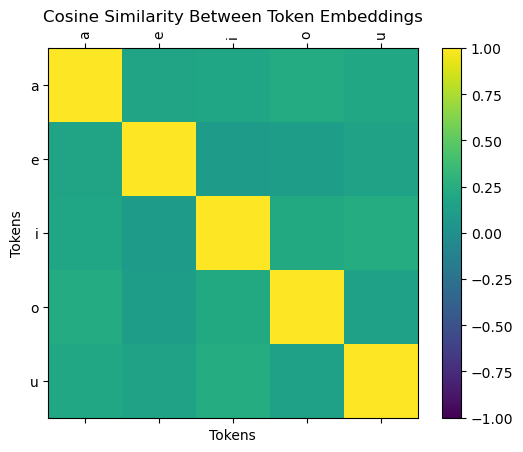

In [71]:
# Example usage with vowels
vowels = ['a', 'e', 'i', 'o', 'u']
plot_token_similarity(vowels, model, stoi)

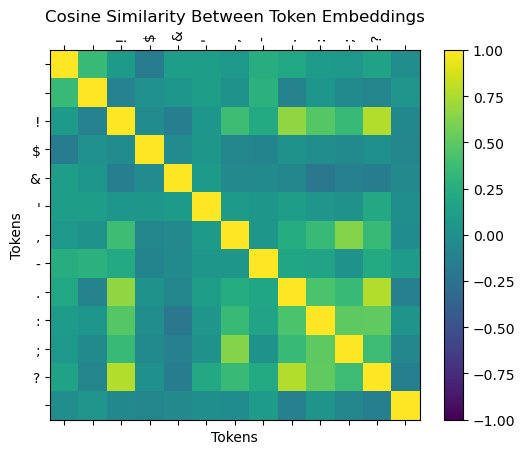

In [72]:
non_alphanumeric = ['\n', ' ', '!', '$', '&', "'", ',', '-', '.', ':', ';', '?', '']
plot_token_similarity(non_alphanumeric, model, stoi)

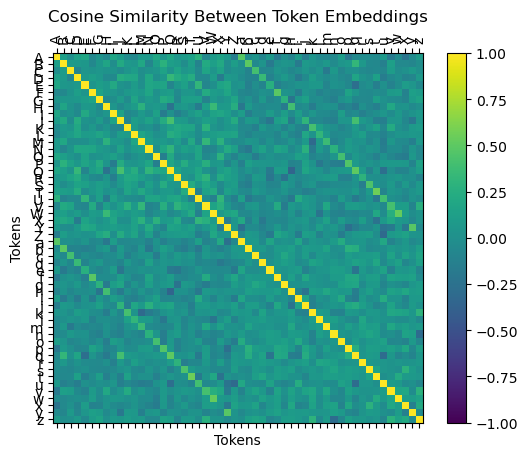

In [73]:
letters = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']
plot_token_similarity(letters, model, stoi)

In [78]:
def visualize_similarity(specific_embeddings, all_embeddings, token_labels):
    """
    Visualizes cosine similarities between specific token embeddings and all token embeddings.

    Parameters:
    - specific_embeddings: A tensor of shape (num_specific_tokens, embedding_dim) containing the embeddings of specific tokens.
    - all_embeddings: A tensor of shape (num_tokens, embedding_dim) containing the embeddings of all tokens in the model.
    - token_labels: A list of all token labels corresponding to `all_embeddings`.
    """
    # Calculate cosine similarity
    similarities = F.cosine_similarity(specific_embeddings.unsqueeze(1), all_embeddings.unsqueeze(0), dim=2)
    
    # Plotting
    fig, ax = plt.subplots(figsize=(10, 10))
    cax = ax.matshow(similarities.t().cpu().numpy(), cmap='viridis', vmin=-1, vmax=1)
    fig.colorbar(cax)

    # Set axis labels
    ax.set_yticks(np.arange(len(token_labels)))
    ax.set_xticks(np.arange(specific_embeddings.size(0)))

    # Label axes with token labels
    ax.set_yticklabels(token_labels, rotation=90)
    ax.set_xticklabels([f'{i+1}' for i in range(specific_embeddings.size(0))])

    ax.set_ylabel('All Tokens')
    ax.set_xlabel('Concept Vectors')

    plt.show()

In [76]:
c_vecs = c_vecs_list[0].squeeze(0)
for i in range(1,len(c_vecs_list)):
    c_vecs = torch.cat((c_vecs, c_vecs_list[i].squeeze(0)), dim=0)

print("c_vecs: ", c_vecs.shape, "\n", c_vecs)
c_vecs[-2,:] == c_vecs[-1,:] # so they don't exactly equal but they do get hella close
# my intuition says they're like converging to an attractor state

c_vecs:  torch.Size([9, 128]) 
 tensor([[ 0.3173,  0.3976, -0.5577,  ...,  0.6611,  0.7742,  1.3494],
        [ 0.5417,  0.3219, -0.5801,  ...,  0.7663,  0.6325,  1.0651],
        [ 0.5093,  0.3427, -0.5914,  ...,  0.7372,  0.6293,  1.0943],
        ...,
        [ 0.5124,  0.3387, -0.5910,  ...,  0.7379,  0.6355,  1.0949],
        [ 0.5124,  0.3387, -0.5910,  ...,  0.7379,  0.6355,  1.0949],
        [ 0.5124,  0.3387, -0.5910,  ...,  0.7379,  0.6355,  1.0949]],
       device='mps:0')


tensor([False, False, False, False,  True, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,  True,
        False, False,  True, False, False, False,  True, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False,  True, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,  True,
        False, False, False, False,  True, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,  True,
        False, False, False, False, False, False,  True, False, False, False,
        False, False, False, False,  True, False, False, False, False, False,
        False,  True, False, False, False, False, False, False, False, False,
        False, False, False,  True, False, False, False, False, False, False,
        False, False, False, False,  True, False, False,  True],

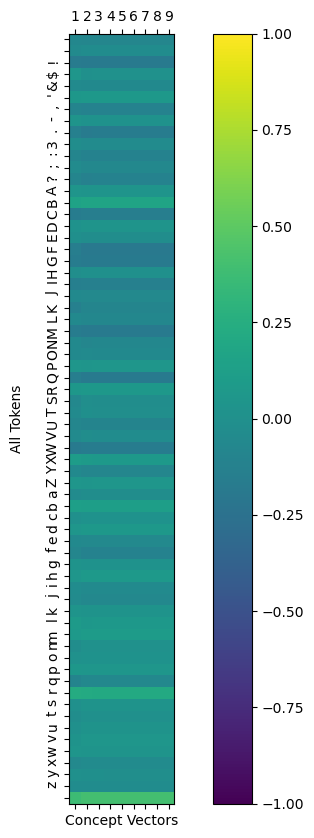

In [79]:
# Example usage
# Assuming `model` is your model instance and `chars` is the list of all characters (tokens)
all_embeddings = model.token_embedding_table.weight.data

# Call the function with specific embeddings, all embeddings, and the token labels
visualize_similarity(c_vecs, all_embeddings, chars)